### 1) Imports

In [99]:
#==========================================================
#                       Imports
#==========================================================
from __future__ import division

import os, sys, time
import h5py as hp
import numpy as np
import matplotlib.pyplot as plt
import pickle
import csv

import NAFFlib as pnf

# Added by Themis
import scipy
#sys.path.append('/Applications/anaconda/pkgs/')
#sys.path.append('/nfsbigdata1/tmastorigrp/src/')

from scipy.constants import m_p, c, e
from mpl_toolkits.mplot3d import Axes3D

from PyHEADTAIL.particles.slicing import UniformBinSlicer
from PyHEADTAIL.particles.generators import generate_Gaussian6DTwiss 
from PyHEADTAIL.trackers.detuners import Chromaticity, AmplitudeDetuning
from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.trackers.simple_long_tracking import RFSystems, LinearMap
from PyHEADTAIL.monitors.monitors import BunchMonitor, SliceMonitor, ParticleMonitor
from PyHEADTAIL.feedback.transverse_damper import TransverseDamper
from PyHEADTAIL.impedances.wakes import CircularResonator, WakeTable, WakeField

%matplotlib inline

In [100]:
params = {'legend.fontsize': 20,
          'figure.figsize': (8, 7),
          'axes.labelsize': 25,
          'axes.titlesize': 21,
          'xtick.labelsize': 23,
          'ytick.labelsize': 23,
          'image.cmap': 'jet',
          'lines.linewidth': 2,
          'lines.markersize': 7,
          'font.family': 'sans-serif'}


plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

In [101]:
plt.close('all')

### 2) Variables we change

In [102]:
#==========================================================
#               Variables We Change
#==========================================================
n_turns = int(600)            #number of cycles to run the simulation for
decTurns = int(1)               #how often to record data

Q_y = 26.18                #How many times the particles oscillate in phase space each turn 
Q_x = 26.13                          # Will need it to be 16.25 IF CC feedback is used
                            # For this version of PyHEADTAIL Q_x should be an array

filename = 'file'      #Where the data for the run is saved

ampNoiseOn = 0              #Turns on the amplitude noise - 0 is off, 1 is on
phaseNoiseOn = 0            #Turns on the phase noise - 0 is off, 1 is on
stdAmpNoise = 1e-8          #Size of amplitude noise (1e-8 for ~22nm/s at 0 ampGain)
stdPhaseNoise = 1e-8      #Size of phase noise (1e-8 for ~24nm/s at 0 phaseGain)

wakefieldOn = 1         # Turns on the wakefields

### 3) Variables we don't change

In [103]:
#==========================================================
#           Variables We (Usually) Do Not Change
#==========================================================

gamma = 287.8
p0 = m_p*c*np.sqrt(gamma**2 - 1)
beta = np.sqrt(1 - 1/gamma**2)
circumference = 6911.5623
frev = 299792458/circumference


# PARAMETERS FOR TRANSVERSE MAP
# =====================
n_segments = 2
s = np.arange(0, n_segments+1)*circumference/n_segments
# optics at CC2
alpha_x = 0 * np.ones(n_segments)  # -0.9120242128
beta_x = 30.31164764 * np.ones(n_segments)
D_x = 0 * np.ones(n_segments) # -0.4954033073
alpha_y = 0 * np.ones(n_segments)  # 1.862209583
beta_y = 73.81671646 * np.ones(n_segments)
D_y = 0 * np.ones(n_segments)


i_wake = 1
# beta_x[i_wake] = 54.65 #### (for Q20)
# beta_y[i_wake] = 54.51 #### (for Q20)
beta_x[i_wake] = 42.0941 #### (for Q26)
beta_y[i_wake] = 42.0137 #### (for Q26)



Q_x, Q_y = 26.13, 26.18
Qp_x, Qp_y = 0, 0 #10

# detuning coefficients in (1/m)
app_x = 0.0  #2.4705e-15 #4e-11
app_xy = 0.0 #-0*2.25e-11
app_y = 0.0  #-7.31-14 #0*3e-11

# PARAMETERS FOR LONGITUDINAL MAP
# =======================
alpha = 1.9e-3
Q_s = 0.0051
h1, h2 = 4620, 9240
V1, V2 = 5.008e6, 0e6
dphi1, dphi2 = 0, np.pi
p_increment = 0 * e/c * circumference/(beta*c)

# CREATE BEAM
# ===========
macroparticlenumber = int(5e5) # at least 5e5 particles are needed in the presence of the wakefields

charge = e
mass = m_p

R = circumference/(2*np.pi)
eta = alpha-1/gamma**2
beta_z = np.abs(eta)*R/Q_s


epsn_x = 2e-6
epsn_y = 2e-6     
#epsn_z    = 2.5
#sigma_z   = 0.155 #2*0.0755

tau = 1.7e-9 # 4 sigma_t [s]
sigma_z = c*tau/4 #0.155  # m
#sigma_z = %sigmaz #0.155
print(f'sigma_z= {sigma_z} [m]')


sigma_x = np.sqrt(epsn_x/(beta*gamma) * beta_x[0])
sigma_xp = sigma_x/beta_x[0]
sigma_y = np.sqrt(epsn_y/(beta*gamma) * beta_y[0])
sigma_yp = sigma_y/beta_y[0]
sigma_dp = sigma_z/beta_z
epsn_z = 4*np.pi * p0/e * sigma_z*sigma_dp

# generate bunches for the different intensities
intensity_list = np.linspace(0, 5e10, 5)
for intensity in intensity_list[1:]:
    intensity = intensity+0.5*intensity
    print(f'Createing bunch for intensity:{intensity}')

    bunch = generate_Gaussian6DTwiss(
        macroparticlenumber, intensity, charge, mass, circumference, gamma,
        alpha_x[0], alpha_y[0], beta_x[0], beta_y[0], beta_z, epsn_x, epsn_y, epsn_z)
    xoffset = 0.15*sigma_x #5e-4
    yoffset = 0.15*sigma_y #0.5*sigma_y #5e-4
    
    bunch.x += xoffset
    bunch.y += yoffset
    
    afile = open(f'bunch_intensity{intensity/1e10}1e10', 'wb')
    pickle.dump(bunch, afile)
    afile.close()



# SLICER FOR WAKEFIELDS
# ============
n_slices = 500 # 500
slicer_for_wakefields = UniformBinSlicer(n_slices, z_cuts=(-3.*sigma_z, 3.*sigma_z))#,circumference=circumference, h_bunch=h1)

# WAKEFIELD
# ==========
n_turns_wake = 1 # for the moment we consider that the wakefield decays after 1 turn
wakefile1=('SPS_complete_wake_model_2018_Q26.txt')


ww1 = WakeTable(wakefile1, ['time', 'dipole_x', 'dipole_y', 'quadrupole_x', 'quadrupole_y'], n_turns_wake=n_turns_wake)

# only dipolar kick
#my_length = len(ww1.wake_table['quadrupole_x'])
#ww1.wake_table['quadrupole_x'] = np.zeros(my_length)
#ww1.wake_table['quadrupole_y'] = np.zeros(my_length)



wake_field_kicker = WakeField(slicer_for_wakefields, ww1)#, beta_x=beta_x, beta_y=beta_y)



sigma_z= 0.12741179465 [m]
Createing bunch for intensity:18750000000.0
Createing bunch for intensity:37500000000.0
Createing bunch for intensity:56250000000.0
Createing bunch for intensity:75000000000.0
dipole_x Assuming ultrarelativistic wake.
dipole_y Assuming ultrarelativistic wake.
quadrupole_x Assuming ultrarelativistic wake.
quadrupole_y Assuming ultrarelativistic wake.


### 4) Create transverse and longitudinal map

In [104]:
scale_factor = 2*bunch.p0  # scale the detuning coefficients in pyheadtail units
transverse_map = TransverseMap(s, alpha_x, beta_x, D_x, alpha_y, beta_y, D_y, Q_x, Q_y,
    [Chromaticity(Qp_x, Qp_y),
    AmplitudeDetuning(app_x*scale_factor, app_y*scale_factor, app_xy*scale_factor)])

longitudinal_map = LinearMap([alpha], circumference, Q_s)

### 5) Set up the acclerator

In [105]:
if ampNoiseOn == 1:
    ampKicks = np.random.normal(0, stdAmpNoise, n_turns)
else:
    ampKicks = np.zeros(n_turns)
if phaseNoiseOn == 1:
    phaseKicks = np.random.normal(0, stdPhaseNoise, n_turns)
else:
    phaseKicks = np.zeros(n_turns)

t0 = time.clock()

one_turn_map = []
for i, segment in enumerate(transverse_map):
    one_turn_map.append(segment)
    if wakefieldOn:
        if i+1 == i_wake:
            one_turn_map.append(wake_field_kicker)
            #one_turn_map.append(wake_field_wall)
one_turn_map.append(longitudinal_map)

n_damped_turns = int(n_turns/decTurns) # The total number of turns at which the data are damped.
                       # We want this number as an integer, so it can be used in the next functions. 


/home/natalia/anaconda3/envs/run_pyheadtail/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.


### 6) Start tracking

In [107]:
meanX = np.zeros(n_damped_turns)
meanY = np.zeros(n_damped_turns)
    
# Iterate over the intensities, reload bunch object from file for each intensisty
#intensity_list = np.linspace(0, 5e10, 5)
for intensity in intensity_list[1:]:
    intensity=intensity+0.5*intensity
    print(f'Tracking for intensity:{intensity}')
    
    file2 = open(f'bunch_intensity{intensity/1e10}1e10', 'rb')
    bunch = pickle.load(file2)
    file2.close()
    for i in range(n_turns):

        # Crab cavity
        Vcc = 1e6
        p_cc = Vcc/(gamma*.938e9)  # Vo/Eb
      
        # Gaussian Amplitude noise
        bunch.yp += ampKicks[i]*np.sin(2*np.pi*400e6/(bunch.beta*c)*bunch.z)

        # Gaussian Phase noise
        bunch.yp += phaseKicks[i]*np.cos(2*np.pi*400e6/(bunch.beta*c)*bunch.z)

        #These next two lines actually "run" the simulation - the computationally heavy part
        for m in one_turn_map:
            m.track(bunch)

        
        if i%decTurns is  0:
            j = int(i/decTurns)
            meanX[j] = np.mean(bunch.x)
            meanY[j] = np.mean(bunch.y)



    dataExport = [meanX, meanY]#, meanXsq, meanYsq, emitX, emitY]

    f = open(filename+f'_intensity{intensity/1e10:.2f}e10_ayy{app_y}_QpyQpx{Qp_x}.txt', 'w')

    with f:
        out = csv.writer(f, delimiter=',')
        out.writerows(zip(*dataExport))

    print('--> Done.')

    print("Simulation time in seconds: " + str(time.clock() - t0))



Tracking for intensity:18750000000.0
--> Done.
Simulation time in seconds: 155.37181699999996
Tracking for intensity:37500000000.0


/home/natalia/anaconda3/envs/run_pyheadtail/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


--> Done.
Simulation time in seconds: 376.019491
Tracking for intensity:56250000000.0
--> Done.
Simulation time in seconds: 597.7486049999998
Tracking for intensity:75000000000.0
--> Done.
Simulation time in seconds: 814.7665510000002


In [108]:
Qx_list, Qy_list = [], []
Qx_list.insert(0, 0.13)
Qy_list.insert(0, 0.18)

for intensity in intensity_list[1:]:
    # Load the file with all of the saved data from the run
    meanX, meanY = np.loadtxt(filename+f'_intensity{intensity/1e10:.2f}e10_ayy{app_y}_QpyQpx{Qp_x}.txt', delimiter = ",", unpack = True)
    
    Qx_list.append(pnf.get_tune(meanX))
    Qy_list.append(pnf.get_tune(meanY))

OSError: file_intensity1.25e10_ayy0.0_QpyQpx0.txt not found.

### Add tune shifts for intensity 0.0 --> is 0.0

In [27]:
Qy_coherent = {}
Qx_coherent = {}
for i, intensity in enumerate(intensity_list):
    Qy_coherent[f'intensity {intensity}'] = Qy_list[i]
    Qx_coherent[f'intensity {intensity}'] = Qx_list[i]
    
save2pickle = False
if save2pickle:
    with open(f'Qy_coherent_vs_Intensity_6D_ayy{app_y}_wakesON_QpyQpx{Qp_x}.pkl', 'wb') as ff:
        pickle.dump(Qy_coherent, ff, pickle.HIGHEST_PROTOCOL)
    ff.close()
    
if save2pickle:
    with open(f'Qx_coherent_vs_Intensity_6D_ayy{app_y}_wakesON_Qpy{Qp_x}.pkl', 'wb') as ff:
        pickle.dump(Qx_coherent, ff, pickle.HIGHEST_PROTOCOL)
    ff.close()

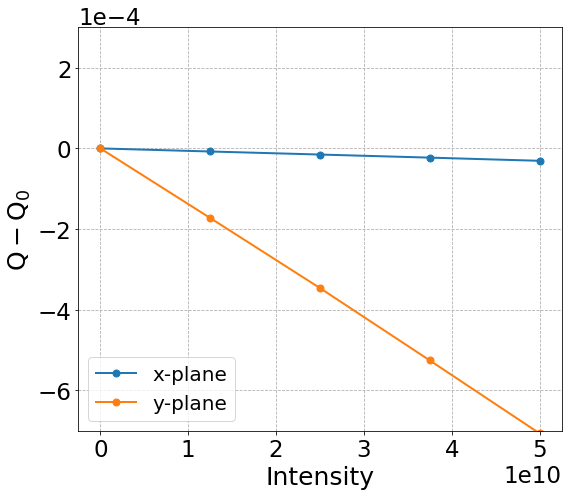

In [29]:
plt.plot(intensity_list, np.array(Qx_list)-0.13, '-o', c='C0', label='x-plane')
plt.plot(intensity_list, np.array(Qy_list)-0.18, '-o', c='C1', label='y-plane')


plt.ylabel(r'$\mathrm{Q-Q_0}$')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.xlabel('Intensity')
plt.grid(linestyle='dashed')
plt.legend(loc=3)

plt.tight_layout()

# axis limits
plt.ylim(-7e-4, 3e-4)#3e-5

savefig = False
if savefig:
    plt.savefig(f'TuneShift_vs_Intensity_Q26wakes_ayy{app_y}_QpxQpy{Qp_x}_sigmaz{sigma_z}.png', bbox_inches='tight')

# Part B: Compare pyheadtail with the theory

In [44]:
### Load theoretical estimation from: https://github.com/natriant/exploring_SPS/tree/master/tuneShift_from_transverese_impedance/theoretical%20model%20(Chao%20formula)

In [45]:
DQy_coherent_theory = pickle.load(open('Qy_coherent_vs_Intensity_Chao_QpyQpx0.0_steps_270GeV_Q26Complete2018_dipolQuads_tau1_7ns.pkl', 'rb'))
DQx_coherent_theory = pickle.load(open('Qx_coherent_vs_Intensity_Chao_QpyQpx0.0_steps_270GeV_Q26Complete2018_dipolaNDQuads_tau1_7ns.pkl', 'rb'))

In [46]:
Qy_coherent_simulation = pickle.load(open('Qy_coherent_vs_Intensity_6D_ayy0.0_wakesON_QpyQpx0_initialOffset15e-2sigmaxy_tau1_7ns.pkl', 'rb'))
Qx_coherent_simulation = pickle.load(open('Qx_coherent_vs_Intensity_6D_ayy0.0_wakesON_Qpy0_initialOffset15e-2sigmaxy_tau1_7ns.pkl', 'rb'))

In [49]:
DQy_list_theory, DQx_list_theory = [], []
Qy_list_simulation, Qx_list_simulation = [], []

for intensity in intensity_list:
    DQy_list_theory.append(DQy_coherent_theory[f'intensity {intensity}'])
    DQx_list_theory.append(DQx_coherent_theory[f'intensity {intensity}'])
    Qy_list_simulation.append(Qy_coherent_simulation[f'intensity {intensity}'])
    Qx_list_simulation.append(Qx_coherent_simulation[f'intensity {intensity}'])

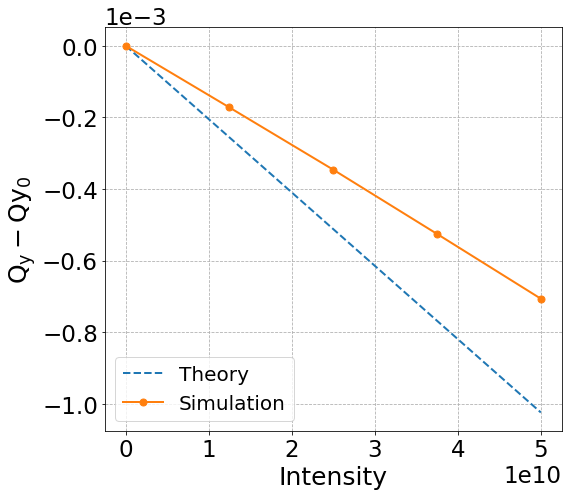

In [82]:
fig, ax = plt.subplots()

ax.plot(intensity_list, DQy_list_theory, '--', c='C0', label='Theory')
ax.plot(intensity_list, np.array(Qy_list_simulation)-0.18, '-o', c='C1', label='Simulation')

ax.set_ylabel(r'$\mathrm{Q_y-Q{y_0}}$')
ax.set_xlabel('Intensity')

ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.grid(linestyle='dashed')
ax.legend(loc=3)

plt.tight_layout()

# axis limits
#ax.set_ylim(-7e-4, 3e-4)#3e-5

savefig = False
if savefig:
    plt.savefig(f'DQy_vs_Intensity_Q26wakes_ayy{app_y}_QpxQpy{Qp_x}_sigmaz{sigma_z}_vsSacherer.png', bbox_inches='tight')

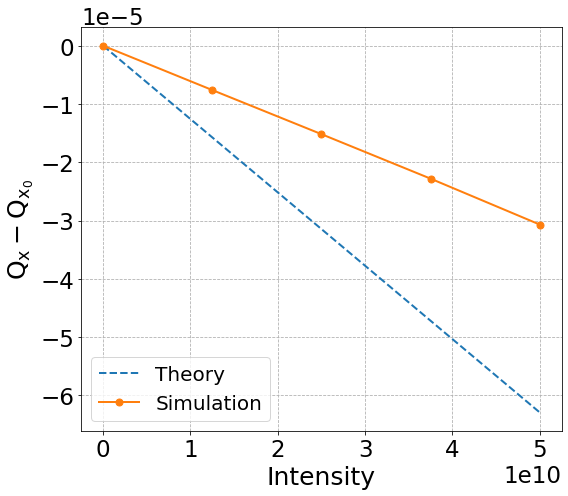

In [83]:
fig, ax = plt.subplots()

ax.plot(intensity_list, DQx_list_theory, '--', c='C0', label='Theory')
ax.plot(intensity_list, np.array(Qx_list_simulation)-0.13, '-o', c='C1', label='Simulation')

ax.set_ylabel(r'$\mathrm{Q_x-Q_{x_0}}$')
ax.set_xlabel('Intensity')

ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.grid(linestyle='dashed')
ax.legend(loc=3)

plt.tight_layout()

# axis limits
#ax.set_ylim(-7e-4, 3e-4)#3e-5

savefig = False
if savefig:
    plt.savefig(f'DQx_vs_Intensity_Q26wakes_ayy{app_y}_QpxQpy{Qp_x}_sigmaz{sigma_z}_vsSacherer.png', bbox_inches='tight')

In [ ]:
## Plot with percentages

In [84]:
Qx_list_theory = np.array(DQx_list_theory)+0.13
Qy_list_theory = np.array(DQy_list_theory)+0.18

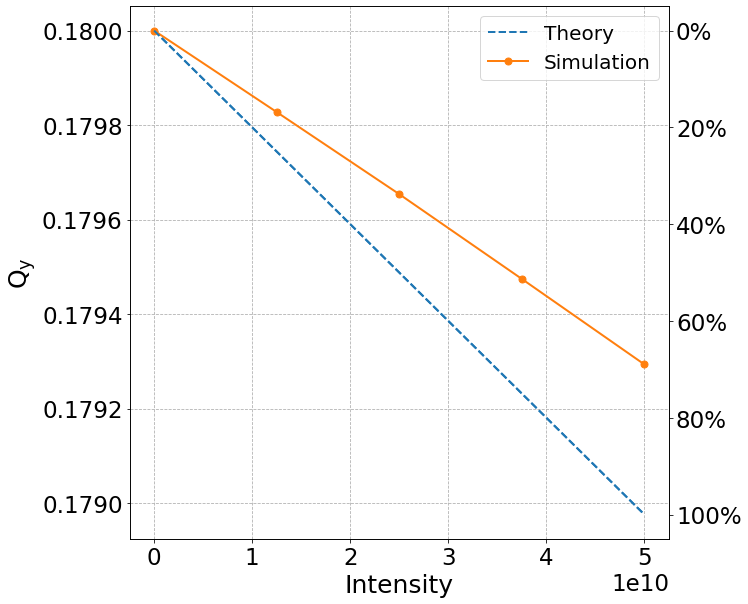

In [92]:
# Plot with percentages


import matplotlib.ticker as mtick

perc = np.linspace(0, 100,len(Qy_list_theory))

fig, ax1 = plt.subplots(1,1, figsize=(10.5, 8.5))

ax1.plot(intensity_list, Qy_list_theory, '--', c='C0', label='Theory')
ax1.plot(intensity_list, np.array(Qy_list_simulation), '-o', c='C1', label='Simulation')


ax1.set_ylabel(r'$\mathrm{Q_y}$')
ax1.set_xlabel('Intensity')


ax2 = ax1.twinx() 
ax2.plot(intensity_list, perc, '--', c='C0')#
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax2.yaxis.set_major_formatter(yticks)
ax2.invert_yaxis()


#ax.set_xlim(0, 35)

ax1.legend()
ax1.ticklabel_format(axis='y', style='', scilimits=None, useOffset=False)#,
#ax1.set_xticks(np.arange(0,40,5))

ax1.grid(ls='--')
plt.tight_layout()

savefig = False 
if savefig:
    plt.savefig('Qy_vs_intensity_vs_Chao_SPS_Q26_QpxQpy0_tau1_7ns_percentages.png')

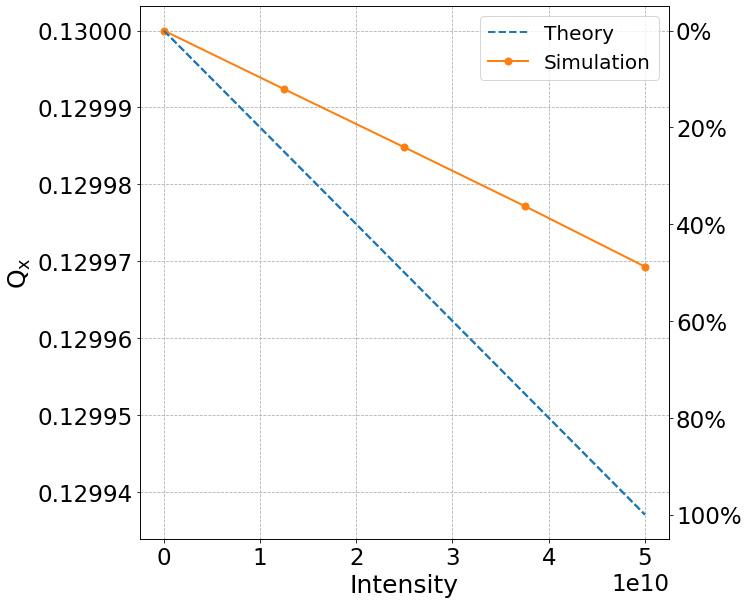

In [93]:
# Plot with percentages


import matplotlib.ticker as mtick

perc = np.linspace(0, 100,len(Qx_list_theory))

fig, ax1 = plt.subplots(1,1, figsize=(10.5, 8.5))

ax1.plot(intensity_list, Qx_list_theory, '--', c='C0', label='Theory')
ax1.plot(intensity_list, np.array(Qx_list_simulation), '-o', c='C1', label='Simulation')


ax1.set_ylabel(r'$\mathrm{Q_x}$')
ax1.set_xlabel('Intensity')


ax2 = ax1.twinx() 
ax2.plot(intensity_list, perc, '--', c='C0')#
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax2.yaxis.set_major_formatter(yticks)
ax2.invert_yaxis()


#ax.set_xlim(0, 35)

ax1.legend()
ax1.ticklabel_format(axis='y', style='', scilimits=None, useOffset=False)#,
#ax1.set_xticks(np.arange(0,40,5))

ax1.grid(ls='--')
plt.tight_layout()


savefig = False 

if savefig:
    plt.savefig('Qx_vs_intensity_vs_Chao_SPS_Q26_QpxQpy0_tau1_7ns_percentages.png')